# Aim
A linear regression analysis is applied to check whether visual network (VIS) and Dorsal Attention Network (DAN) or Default Mode Network (DMN) are hierarchically connected to each other.
# Data analysis order
1. Load all the data (connectivity during attention and resting) : connAtten, connRest
2. Extract only necessary part of the data and reorganize it
 (connectivity between DAN-VIS, DMN-VIS)
3. Linear regression fit : gain, base will be obtained
4. Visualize the Linear Regression plot
5. Visualize the Gain, Base (as a bar plot)

In [1]:
# load libraries (python2)
import pandas as pd
import scipy 
from scipy import mean
from scipy.stats import sem, t
import numpy as np
import scipy.io as sio
import os
import fnmatch, re
import glob
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Define Basic

In [2]:
# Define basie parameters
n_roi = 24; n_subj = 20

# V1, V2, V3, V4, V5, FEF, IPS, MFC, PCC
combI =  [[0,1],[2,3],[4,5],[6],[7],[8],[9],[10],[11]]
conds = ['corrAtten', 'corrRest']
hemis = ['L', 'R']
n_vis = 5; n_dxn = 4; n_hemi = 2; n_subj = 20
n_comb = len(combI)
n_conds = len(conds)

# Directory setup
dir_main = '/Users/soyoung/Python_Stimulus/LinearRegression_Connectivity/'
dir_connectivity = dir_main + "/01_DataConnectivity/"

# dir_main = "/Volumes/SoyoungBackup/Mac_HD3/Atten_Motion_OnOff/LinearRegression_Connectivity/"
# dir_connectivity = dir_main + "/01_DataConnectivity/"
 
prefix = "Conn_rand32_craf_regMotionWM_highnone_low0_P_shift20_regMeanSubjVox_sub"
filetype = prefix + "*[!wrong][!retino].mat"

# 1. Load the data

In [3]:
# load connectivity data : conn_group['atten','rest'](n_roi, n_roi, all_subj)
conn_group = {}
def load_data_group(dir_connectivity, filetype):#, cond):
    # Load the file list
    conn_list = [f for f in glob.glob(dir_connectivity + filetype)]
    
    # Predefine group data and assign it
    for c in range(n_conds):
        conn_group[conds[c]] = np.zeros([n_roi, n_roi, n_subj])
        for s in range(n_subj):
            conn_subj = sio.loadmat(conn_list[s])
            conn_group[conds[c]][:,:,s] = np.mean(conn_subj[conds[c]], axis = 2)
    return conn_group

In [4]:
conn_group = load_data_group(dir_connectivity, filetype)

# 2. Extract & reorganize data
1. Extract Left, Right Data => L-L, L-R, R-R, R-L
2. Extract DAN-VIS, DMN-VIS

In [5]:
# Data combine: dataROIcomb['corrAttenL(R)', 'corrRestL(R)'](n_comb, n_comb, all_subj)
# n_roi -> n_roi/2 -> 9 ROIs
# Reshape into one hemi only (n_roi,n_roi,all_subj) ==> (n_roi/2, n_roi/2, all_subj)
# Combine different ROIs : V1d, V1v ==> V1 (9, 9, all_subj)
dataROIcomb = {}
def data_reorg_LR_comb(data_both):#, condName, hemi):
    for hemi in hemis:
        for c in conds:
            # predefine result, get the input
            dataROIcomb[c + hemi] = np.zeros([n_comb, n_comb, n_subj])
            data_cond = data_both[c]

            # DAN hemisphere (L : odd, R: even)
#             [n_roi, n_roi, n_subj] = data_cond.shape
            if hemi == 'L': oddeven = 0
            elif hemi == 'R': oddeven = 1
            data_half_test = data_cond[list(range(oddeven, n_roi, 2)), :, :] # DAN hemi (input)
            data_half_XL   = data_half_test[:, list(range(0, n_roi, 2)), :] # VIS hemi(L)
            data_half_XR   = data_half_test[:, list(range(1, n_roi, 2)), :] # VIS hemi(R)

            # combine LL+LR
            dataLR = np.zeros([n_roi/2, n_roi/2, n_subj, 2])
            dataLR[:,:,:,0] = data_half_XL; dataLR[:,:,:,1] = data_half_XR;
            dataLR = np.mean(dataLR, axis=3)  

            # combine different ROIs
            # V1d, V1v = > V1
#             dataROIcomb = {(condName + hemi): np.zeros([n_comb, n_comb, n_subj])}
            for x in range(n_comb):
                for y in range(n_comb):
                    dataROIcomb_temp = np.mean(dataLR[:, combI[y], :], axis = 1)
                    dataROIcomb[(c + hemi)][x,y,:] = np.mean(dataROIcomb_temp[combI[x], :], axis =0)
    return dataROIcomb

In [6]:
# Extract DAN (or DMN) - VIS only
# DAN(DMN)-VIS (FEF,IPS,PCC,MFC- V1,V2,V3,V4,V5/MT) ==> (4,5,all_subj)
DXN_VIS = {}
def data_dxn_only(dataROIcomb):
    for hemi in hemis:
        for c in conds:
            # preassign result
            DXN_VIS[c + hemi] = np.zeros([n_dxn, n_vis, n_subj])
            data_cond = dataROIcomb[c + hemi]
            
            # only extract vis Index, DXN index
            All_VIS = data_cond[ :, np.arange(n_vis), :]
            DXN_VIS[c + hemi] = All_VIS[n_vis + np.arange(n_dxn), :, :]
    return DXN_VIS

In [7]:
# Extract DATA
datacomb = data_reorg_LR_comb(conn_group)#, 'L')
DXN_VIS = data_dxn_only(datacomb)
DXN_VIS['corrRestL'].shape

(4, 5, 20)

# 3. Linear Regression

In [8]:
# Linear regression in each subject
DXN_Name = ['FEF','IPS','MFC','PCC']
X = pd.DataFrame(np.arange(5))
Y = DXN_VIS#['corrRestL']

In [9]:
# linear_result['Gain', 'Base', 'Fitted Y']
linear_result = {}
def linear_regression(X, Y, DXN_Name):   
    for hemi in hemis:
        for c in conds:
            # preassign result
            linear_result['Gain ' + c + hemi] = np.zeros([n_subj, n_dxn])
            linear_result['Base ' + c + hemi] = np.zeros([n_subj, n_dxn])
            linear_result['Fitted Y ' + c + hemi] = np.zeros([n_subj, n_dxn, n_vis])
            for dxn in range(4):
                for s in range(n_subj):
                    Y_pd = pd.DataFrame(Y[c + hemi][dxn, :, s])
                    lr = LinearRegression()#(normalize=True)
                    lr.fit(X, Y_pd)
                    pred_Y = lr.predict(X)
                    linear_result['Fitted Y ' + c + hemi][s,dxn,0:n_vis] = pred_Y[:,0]
                    linear_result['Gain ' + c + hemi][s,dxn] = lr.coef_  
                    linear_result['Base '+ c + hemi][s,dxn] = lr.intercept_
    return linear_result

In [10]:
# combine L + R
# for hemi in hemis
linear_LR = linear_regression(X, Y, DXN_Name)
g={}; b={};
def comb_linear_regress(gain_base):
    for c in range(len(conds)):
        # predefine result
        g[conds[c]] = np.zeros([n_subj, n_dxn*2]);
        b[conds[c]] = np.zeros([n_subj, n_dxn*2]);
        # gain, base
        g[conds[c]][ :,list(range(0,8,2))]=gain_base['Gain ' + conds[c] + 'L']
        g[conds[c]][ :,list(range(1,8,2))]=gain_base['Gain ' + conds[c] + 'R']
        b[conds[c]][ :,list(range(0,8,2))]=gain_base['Base ' + conds[c] + 'L']
        b[conds[c]][ :,list(range(1,8,2))]=gain_base['Base ' + conds[c] + 'R']
    return g, b

In [11]:
# combine L+R linear regression
[g,b] = comb_linear_regress(linear_LR)

# only difference
gain_diff = g['corrAtten']-g['corrRest']
base_diff = b['corrAtten']-b['corrRest']
dxnI = np.arange(8)
danI = dxnI[0:4]

# 5. Visualize Gain, Base (diff)

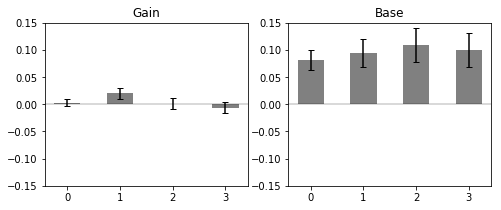

In [12]:
# plot DAN-VIS only

fig = plt.figure(figsize=(8,3))
plt.subplot(1,2,1); plt.title('Gain')
plt.bar(np.arange(4), np.mean(gain_diff[:,danI], axis=0),\
        yerr=scipy.stats.sem(gain_diff[:,danI]), capsize=3, color='grey', width = 0.5); 
plt.axhline(0, color='black', linewidth = 0.3)
plt.ylim(-0.15, 0.15)

plt.subplot(1,2,2); plt.title('Base')
plt.bar(np.arange(4), np.mean(base_diff[:,danI], axis=0), \
        yerr=scipy.stats.sem(base_diff[:,danI]), capsize=3, color='grey', width = 0.5); 
plt.axhline(0, color='black', linewidth = 0.3)
plt.ylim(-0.15, 0.15)
plt.show()

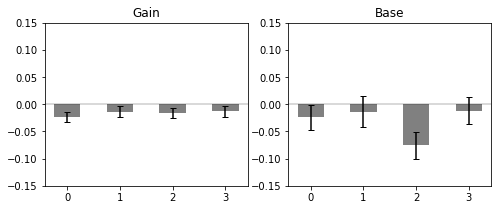

In [13]:
# plot DMN-VIS only
dmnI = dxnI[4:]
fig = plt.figure(figsize=(8,3))

plt.subplot(1,2,1); plt.title('Gain')
plt.bar(np.arange(4), np.mean(gain_diff[:,dmnI], axis=0),\
        yerr=scipy.stats.sem(gain_diff[:,dmnI]), capsize=3, color='grey', width = 0.5); 
plt.axhline(0, color='black', linewidth = 0.3)
plt.ylim(-0.15, 0.15)

plt.subplot(1,2,2); plt.title('Base')
plt.bar(np.arange(4), np.mean(base_diff[:,dmnI], axis=0), \
        yerr=scipy.stats.sem(base_diff[:,dmnI]), capsize=3, color='grey', width = 0.5); 
plt.axhline(0, color='black', linewidth = 0.3)
plt.ylim(-0.15, 0.15)
plt.show()


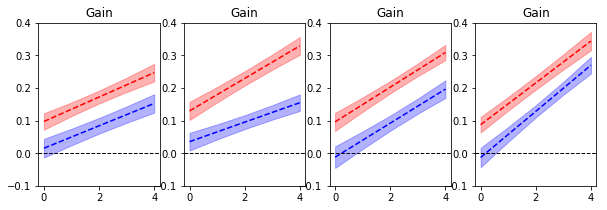

In [30]:
fig = plt.figure(figsize=(10,3))
x= np.arange(5)
for d in range(2): # FEF/IPS
    for h in range(len(hemis)): # L/R
        # one hemi
        # atten
        fit_atten = linear_result['Fitted Y corrAtten' + hemis[h]][:,d,:]
        mean_atten = mean(fit_atten, axis=0)
        std_atten = scipy.stats.sem(fit_atten, axis=0)

        # rest
        fit_rest = linear_result['Fitted Y corrRest' + hemis[h]][:,d,:]
        mean_rest = mean(fit_rest, axis=0)
        std_rest = scipy.stats.sem(fit_rest, axis=0)

        plt.subplot(1,4,h+1+2*d); plt.title('Gain')
        plt.plot(x, mean_atten, 'r--')
        plt.fill_between(x, mean_atten-std_atten, mean_atten+std_atten, alpha =0.3, color = 'r')
        plt.plot(x, mean_rest, 'b--')
        plt.fill_between(x, mean_rest-std_rest, mean_rest+std_rest, alpha =0.3, color = 'b')
        plt.axhline(0, color='k', linestyle = '--', linewidth = 1)        
        plt.ylim(-0.1, 0.4)
plt.show()

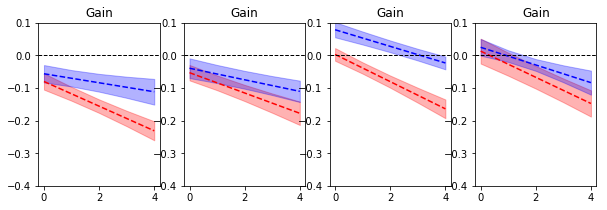

In [29]:
fig = plt.figure(figsize=(10,3))
x= np.arange(5)
for d in range(2,4,1): # FEF/IPS
    for h in range(len(hemis)): # L/R
        # one hemi
        # atten
        fit_atten = linear_result['Fitted Y corrAtten' + hemis[h]][:,d,:]
        mean_atten = mean(fit_atten, axis=0)
        std_atten = scipy.stats.sem(fit_atten, axis=0)

        # rest
        fit_rest = linear_result['Fitted Y corrRest' + hemis[h]][:,d,:]
        mean_rest = mean(fit_rest, axis=0)
        std_rest = scipy.stats.sem(fit_rest, axis=0)

        plt.subplot(1,4,h+1+2*(d-2)); plt.title('Gain')
        plt.plot(x, mean_atten, 'r--')
        plt.fill_between(x, mean_atten-std_atten, mean_atten+std_atten, alpha =0.3, color = 'r')
        plt.plot(x, mean_rest, 'b--')
        plt.fill_between(x, mean_rest-std_rest, mean_rest+std_rest, alpha =0.3, color = 'b')
        plt.axhline(0, color='k', linestyle = '--', linewidth = 1)
        plt.ylim(-0.4, 0.1)
plt.show()

In [18]:
linear_result['Fitted Y corrAtten' + hemis[h]].shape

(20, 4, 5)